# 🎲 Monte Carlo Simulation for Slot Machine — Risk Analysis & Strategy

## 📌 What this project does
Simulates a 3-reel slot machine thousands of times to estimate:
- **Probabilities distribution** (PDF) & **cumulative probabilities** (CDF)
- **Expected value (EV)** per spin & **house edge**
- **Bankroll trajectory** and **risk of ruin** for different bet sizes
- **1000 Simulations** of 200 Spins Each
---

## 🧩 Game model (example)
- **Reels (uniform):** `['Sevens','Black Bar','Cherries','Orange Bar','Green Bar','Blue Bar']`
- **Winning patterns (prize × bet):**

| Pattern                    | Multiplier | Example Probability |
|---------------------------|-----------:|--------------------:|
| 3 Sevens                  | 250×       | 0.000244            |
| 3 Black Bars              | 15×        | 0.000824            |
| 3 Cherries                | 12×        | 0.000244            |
| 2 Cherries + 1 Symbol     | 8×         | 0.010986            |
| 1 Cherry + 2 Symbols      | 2×         | 0.164795            |
| 3 Orange Bar              | 10×        | 0.006592            |
| 3 Green Bar               | 8×         | 0.015625            |
| 3 Blue Bar                | 6×         | 0.040619            |

> You can tweak **multipliers** and **probabilities** to match a specific machine.

---

## 🧮 Core metrics

### Expected value (EV) per spin
\[
\text{EV} = \sum_i p_i \cdot (\text{mult}_i - 1)\cdot b
\]
where \(p_i\) = outcome probability, \(\text{mult}_i\) = payout multiple, \(b\) = bet.

**House edge**
\[
\text{House Edge} = -\frac{\text{EV}}{b}
\]

### Risk of ruin (approx., negative EV, flat bet)
For bankroll \(B\), bet \(b\), edge \(e<0\), variance \(\sigma^2\) of net return per spin, over \(n\) spins:
\[
\text{RoR} \approx \Phi\!\left(-\frac{B + n\cdot e\,b}{\sqrt{n}\,\sigma b}\right)
\]
(\(\Phi\) = standard normal CDF). The simulation also estimates this empirically.

---

## 🔁 What the simulation runs
1. **Spin generator:** random reels → outcome.
2. **Payout engine:** maps outcomes → prize multiple.
3. **Monte Carlo loop:** updates bankroll over `N` spins (or until bust).
4. **Tracking:**  
   - bankroll path (`money_per_run`)  
   - win counts by prize  
   - winning combinations histogram  
   - final balance & number of plays before bust

---

## 📈 Plots you’ll see
- **PDF/CDF of outcomes** (bar/line)  
- **Bankroll trajectory** (money vs. spins)  
- **Histogram of winning combinations**  
- **Win frequency by prize tier**

> Example: your PDF/CDF figures (left = probability by prize; right = cumulative).



---

## 🧰 How to run
1. Install deps: `pip install numpy pandas matplotlib`
2. In the notebook/script:
   - Set `starting_money`, `bet_amount`, `num_simulations`
   - Adjust `multipliers` and `probabilities` if needed
3. Run `play()` to interactively simulate and render plots.

---

## 🧠 What to look for
- If **EV < 0**, long-run loss is expected; strategy mainly changes **variance & time-to-ruin**, not profitability.  
- **Large multipliers with tiny probabilities** create **fat tails**: most paths drift down, a few spike up.
- **Bet size vs. bankroll** dominates **risk of ruin**: smaller bets → longer survival, tighter distribution.




### Importing Libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

### Research Methods and Data Analysis

#### The Base Model/The Simplest One

In [ ]:
# Define the symbols for each of the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Create function to speen the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Create function for winning condition
def check_win(reels):
    if reels[0] == reels[1] == reels[2]:
        return True
    return False

# Main game loop
def play():
    while True:
        input("Press enter to spin the reels...")
        reels = spin()
        print("Spinning...")
        print(f"Reels: {reels}")

        if check_win(reels):
            print("Congratulations! You won!")
        else:
            print("Sorry, you didn't win this time.")

        play_again = input("Do you want to play again? (yes/no): ")
        if play_again.lower() != 'yes':
            print("Thanks for playing!")
            break

# Start the game
play()

Press enter to spin the reels...100
Spinning...
Reels: ['Green Bar', 'Sevens', 'Blue Bar']
Sorry, you didn't win this time.
Do you want to play again? (yes/no): yes
Press enter to spin the reels...100
Spinning...
Reels: ['Black Bar', 'Blue Bar', 'Green Bar']
Sorry, you didn't win this time.
Do you want to play again? (yes/no): no
Thanks for playing!


####we add the amount of times we run the simulation


In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win
def check_win(reels):
    if reels[0] == reels[1] == reels[2]:
        return True
    return False

# Main simulation function
def run_simulation(num_simulations):
    total_wins = 0
    for _ in range(num_simulations):
        reels = spin()
        if check_win(reels):
            total_wins += 1
    return total_wins

# Function to play the simulation
def play():
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))
    wins = run_simulation(num_simulations)
    print(f"Out of {num_simulations} simulations, you won {wins} times.")

# Run the simulation
play()


Enter the number of times you want to run the simulation: 100
Out of 100 simulations, you won 6 times.


####now we add starting capital and the amount to bet (constant)

In [ ]:
# Define the symbols for the reels and their corresponding multipliers
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']
multipliers = {
    'Sevens-Sevens-Sevens': ('Jackpot!', 10),
    'Black Bars-Black Bars-Black Bars': ('Big Win!', 5),
    'Cherries-Cherries-Cherries': ('Medium Win', 2),
    'Orange Bar-Orange Bar-Orange Bar': ('Small Win', 1.5),
    'Green Bar-Green Bar-Green Bar': ('Small Win', 1.5),
    'Blue Bar-Blue Bar-Blue Bar': ('Small Win', 1.5)
}

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)
    if reels[0] == reels[1] == reels[2]:
        return outcome, *multipliers.get(outcome, ('Congratulations! You won!', 0))
    return outcome, 'Sorry, you didn\'t win this time.', 0

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []
    current_money = starting_money
    play_count = 0
    for _ in range(num_simulations):
        if current_money < bet_amount:
            print(f"Sorry, you can't play anymore. You're bankrupt after playing {play_count} times!")
            break

        reels = spin()
        outcome, prize_info, prize_multiplier = check_win(reels)
        if prize_multiplier > 0:
            outcomes_and_prizes.append((outcome, prize_info, prize_multiplier))
            prize_money = bet_amount * prize_multiplier
            current_money += prize_money - bet_amount
        else:
            current_money -= bet_amount
        play_count += 1
    return outcomes_and_prizes, current_money, play_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes, final_money, plays_before_bankrupt = run_simulation(num_simulations, starting_money, bet_amount)

    print(f"\nFinal Money: ${final_money}")
    print(f"\nOutcomes and Prizes for {len(outcomes)} wins:")
    for i, (outcome, prize_info, prize_multiplier) in enumerate(outcomes, 1):
        prize_money = bet_amount * prize_multiplier
        print(f"{i}. Outcome: {outcome}, Prize: {prize_info}, Prize Multiplier: {prize_multiplier}x, Prize Money: ${prize_money}")
    if final_money < bet_amount:
        print(f"\nYou played {plays_before_bankrupt} times before going bankrupt.")

# Run the simulation
play()


Enter your starting amount of money: $1000
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200
Sorry, you can't play anymore. You're bankrupt after playing 114 times!

Final Money: $5.0

Outcomes and Prizes for 4 wins:
1. Outcome: Sevens-Sevens-Sevens, Prize: Jackpot!, Prize Multiplier: 10x, Prize Money: $100.0
2. Outcome: Orange Bar-Orange Bar-Orange Bar, Prize: Small Win, Prize Multiplier: 1.5x, Prize Money: $15.0
3. Outcome: Blue Bar-Blue Bar-Blue Bar, Prize: Small Win, Prize Multiplier: 1.5x, Prize Money: $15.0
4. Outcome: Orange Bar-Orange Bar-Orange Bar, Prize: Small Win, Prize Multiplier: 1.5x, Prize Money: $15.0

You played 114 times before going bankrupt.


####now we add a list of what we win and plot a graph of our remaining balance per run

Enter your starting amount of money: $1000
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200

Outcomes and Prizes:
                            Outcome       Prize
0       Sevens-Green Bar-Orange Bar     Big Win
1      Green Bar-Cherries-Green Bar     Big Win
2        Blue Bar-Cherries-Cherries  Medium Win
3            Blue Bar-Sevens-Sevens  Medium Win
4         Blue Bar-Green Bar-Sevens     Big Win
5           Sevens-Sevens-Black Bar   Small Win
6     Black Bar-Black Bar-Black Bar   Small Win
7       Blue Bar-Black Bar-Blue Bar  Medium Win
8      Blue Bar-Green Bar-Green Bar  Medium Win
9       Sevens-Orange Bar-Black Bar  Medium Win
10      Green Bar-Blue Bar-Cherries  Medium Win
11        Cherries-Black Bar-Sevens   Small Win
12        Green Bar-Cherries-Sevens     Jackpot
13       Cherries-Sevens-Orange Bar   Small Win
14       Sevens-Cherries-Orange Bar   Small Win
15     Black Bar-Cherries-Green Bar     Big Win
16     Blue Bar-Orange Bar-Blu

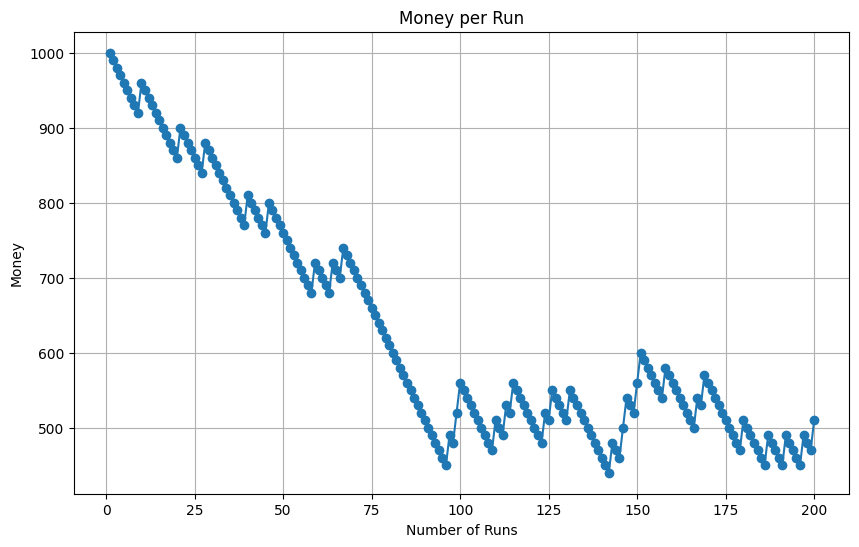

In [ ]:
# Define the symbols for the reels and their corresponding multipliers
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']
probabilities = {
    'Jackpot': 0.01,
    'Big Win': 0.05,
    'Medium Win': 0.1,
    'Small Win': 0.15
}

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)
    result = random.random()
    for prize, probability in probabilities.items():
        if result < probability:
            return prize, True
    return 'No Win', False

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []
    money_per_run = []
    current_money = starting_money
    play_count = 0
    win_count = {prize: 0 for prize in probabilities.keys()}

    for _ in range(num_simulations):
        money_per_run.append(current_money)
        if current_money < bet_amount:
            break

        reels = spin()
        prize, is_win = check_win(reels)

        if is_win:
            outcomes_and_prizes.append((outcome := '-'.join(reels), prize))
            current_money += bet_amount * 5 - bet_amount  # Assume all wins are 5x the bet amount
            win_count[prize] += 1
        else:
            current_money -= bet_amount
        play_count += 1

    return outcomes_and_prizes, money_per_run, win_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes, money_per_run, win_count = run_simulation(num_simulations, starting_money, bet_amount)

    if outcomes:
        outcomes_df = pd.DataFrame(outcomes, columns=['Outcome', 'Prize'])
        print("\nOutcomes and Prizes:")
        print(outcomes_df)
    else:
        print("\nNo wins in the simulation.")

    win_count_df = pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency'])
    win_count_df.index.name = 'Prize'
    print("\nPrize Frequency:")
    print(win_count_df)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

# Run the simulation
play()


####now we differentiate between multipliers and probabilities for the prizes. We also test our model if we add other win conditions

Enter your starting amount of money: $1000
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200

Outcomes and Prizes:
                           Outcome       Prize
0        Sevens-Black Bar-Blue Bar   Bonus Win
1    Black Bar-Orange Bar-Blue Bar  Medium Win
2    Cherries-Orange Bar-Black Bar   Extra Win
3      Sevens-Green Bar-Orange Bar   Small Win
4           Cherries-Sevens-Sevens   Extra Win
..                             ...         ...
58     Blue Bar-Blue Bar-Green Bar   Bonus Win
59    Cherries-Orange Bar-Cherries  Medium Win
60  Orange Bar-Orange Bar-Cherries   Small Win
61    Cherries-Cherries-Orange Bar   Small Win
62  Cherries-Orange Bar-Orange Bar   Bonus Win

[63 rows x 2 columns]

Prize Frequency:
            Frequency
Prize                
Jackpot             1
Big Win             2
Medium Win          7
Small Win           8
Bonus Win          19
Extra Win          26


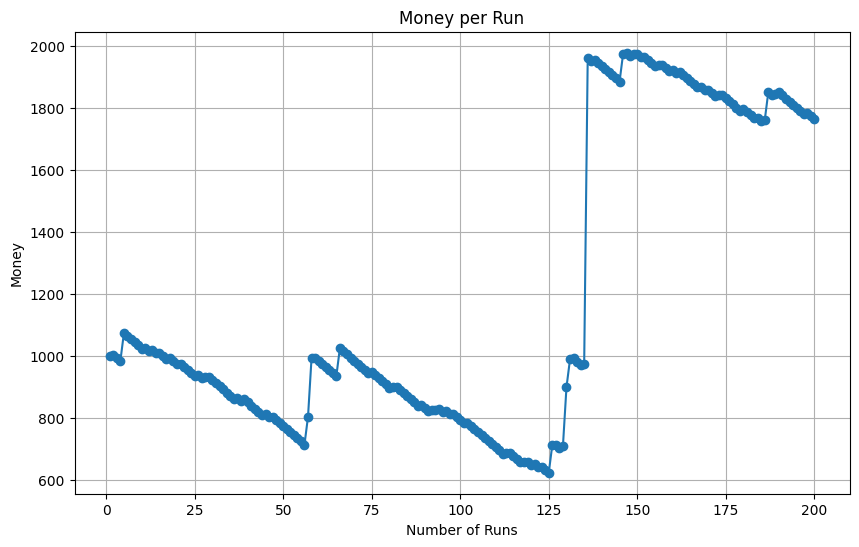

In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    'Jackpot': 100,
    'Big Win': 20,
    'Medium Win': 10,
    'Small Win': 1.5,
    'Bonus Win': 1.3,
    'Extra Win': 1.1
}

probabilities = {
    'Jackpot': 0.001,
    'Big Win': 0.005,
    'Medium Win': 0.05,
    'Small Win': 0.1,
    'Bonus Win': 0.2,
    'Extra Win': 0.33
}

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)
    result = random.random()
    for prize, probability in probabilities.items():
        if result < probability:
            return prize
    return 'No Win'

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []
    money_per_run = []
    current_money = starting_money
    play_count = 0
    win_count = {prize: 0 for prize in probabilities.keys()}

    for _ in range(num_simulations):
        money_per_run.append(current_money)
        if current_money < bet_amount:
            break

        reels = spin()
        prize = check_win(reels)

        if prize != 'No Win':
            outcomes_and_prizes.append((outcome := '-'.join(reels), prize))
            current_money += bet_amount * multipliers[prize] - bet_amount
            win_count[prize] += 1
        else:
            current_money -= bet_amount
        play_count += 1

    return outcomes_and_prizes, money_per_run, win_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes, money_per_run, win_count = run_simulation(num_simulations, starting_money, bet_amount)

    if outcomes:
        outcomes_df = pd.DataFrame(outcomes, columns=['Outcome', 'Prize'])
        print("\nOutcomes and Prizes:")
        print(outcomes_df)
    else:
        print("\nNo wins in the simulation.")

    win_count_df = pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency'])
    win_count_df.index.name = 'Prize'
    print("\nPrize Frequency:")
    print(win_count_df)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

# Run the simulation
play()

####we add the combination frequencies, remaining balance after we finished playing, and histogram of winning combinations

Enter your starting amount of money: $1000
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


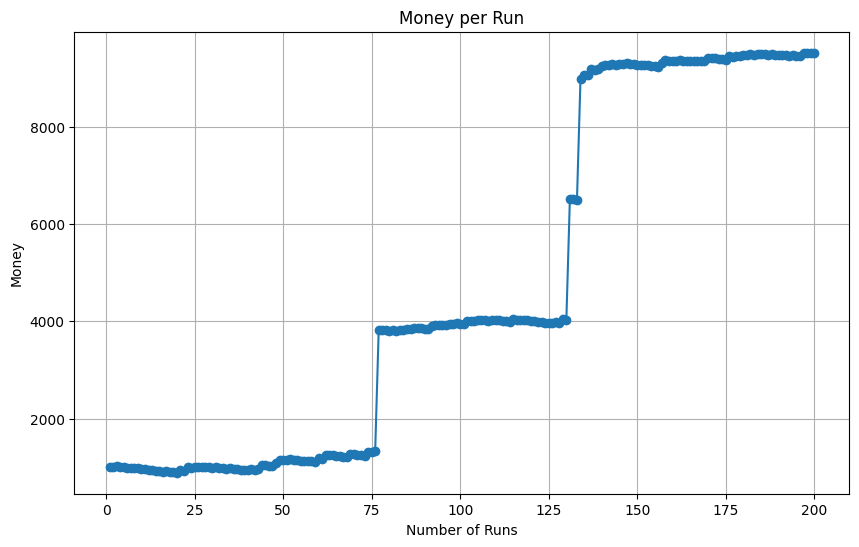


Outcomes and Prizes:
                          Outcome                  Prize
0     Green Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
1       Cherries-Green Bar-Sevens   1 Cherry + 2 Symbols
2     Cherries-Green Bar-Blue Bar   1 Cherry + 2 Symbols
3     Blue Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
4      Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
..                            ...                    ...
85  Orange Bar-Green Bar-Cherries   1 Cherry + 2 Symbols
86      Cherries-Sevens-Black Bar   1 Cherry + 2 Symbols
87     Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
88    Black Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
89     Blue Bar-Blue Bar-Blue Bar             3 Blue Bar

[90 rows x 2 columns]

Prize Frequency:
                       Frequency
3 Sevens                       3
3 Black Bars                   0
3 Cherries                     1
2 Cherries + 1 Symbol         16
1 Cherry + 2 Symbols          65
3 Orange Bar                   1
3 Green Bar           

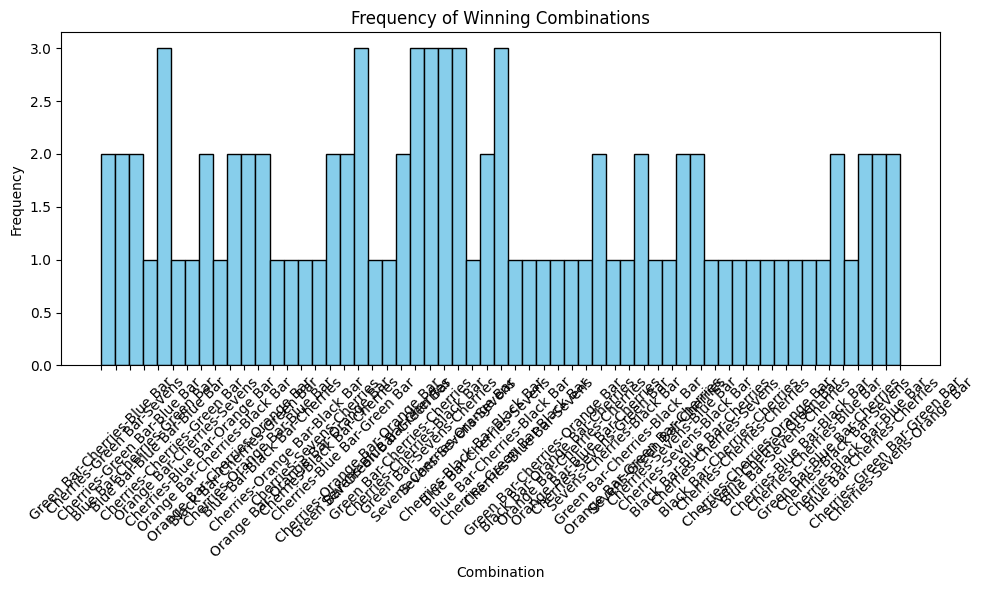


Final Balance after 200 simulations: $9560.00


In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1:
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting

    for _ in range(num_simulations):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Plotting histogram for winning combinations
    if win_combinations:
        plt.figure(figsize=(10, 6))
        plt.hist(win_combinations, bins=len(set(win_combinations)), color='skyblue', edgecolor = 'black')
        plt.title('Frequency of Winning Combinations')
        plt.xlabel('Combination')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")

# Run the simulation
play()

####now we add "bonus spin" condition

Enter your starting amount of money: $1000
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


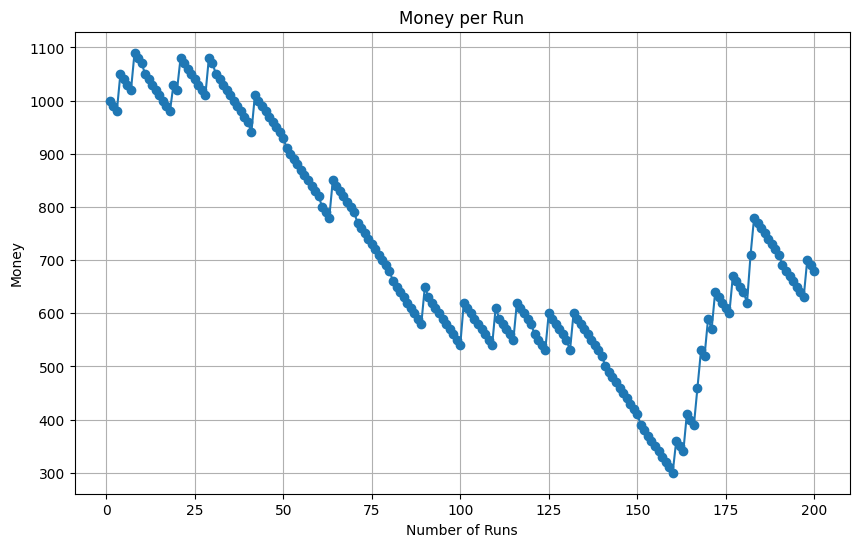


Outcomes and Prizes:
                             Outcome                  Prize
0         Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
1      Green Bar-Green Bar-Green Bar            3 Green Bar
2         Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
3         Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
4           Sevens-Cherries-Cherries  2 Cherries + 1 Symbol
5           Cherries-Cherries-Sevens  2 Cherries + 1 Symbol
6           Cherries-Cherries-Sevens  2 Cherries + 1 Symbol
7         Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
8   Orange Bar-Orange Bar-Orange Bar           3 Orange Bar
9        Black Bar-Cherries-Cherries  2 Cherries + 1 Symbol
10      Cherries-Cherries-Orange Bar  2 Cherries + 1 Symbol
11          Cherries-Cherries-Sevens  2 Cherries + 1 Symbol
12        Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
13       Cherries-Cherries-Black Bar  2 Cherries + 1 Symbol
14          Cherries-Cherries-Sevens  2 Cherries + 1 Symbol
15       Cherries-

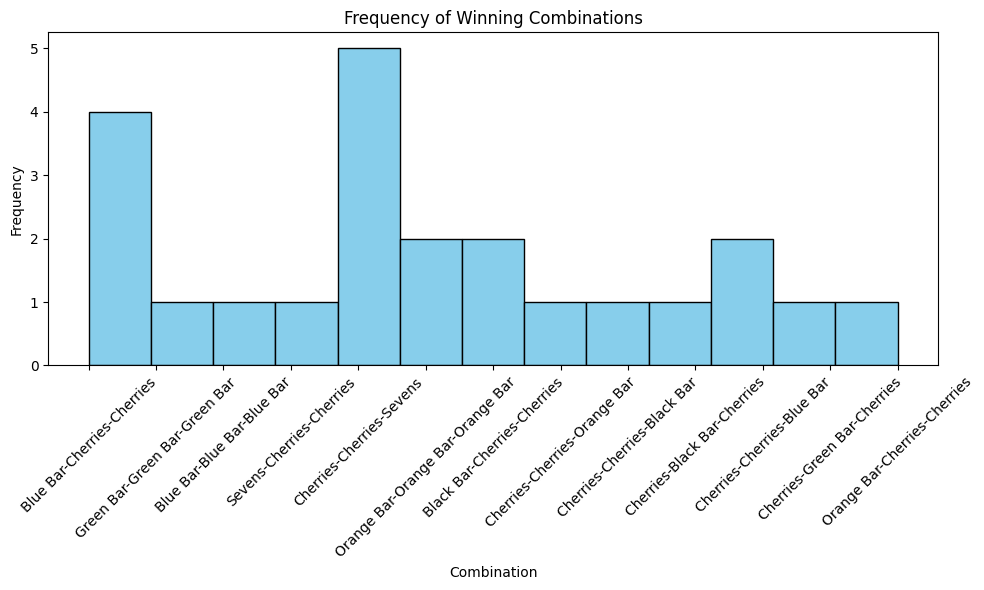


Final Balance after 200 simulations: $660.00
Number of Bonus Spins obtained: 20


In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1:
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Plotting histogram for winning combinations
    if win_combinations:
        plt.figure(figsize=(10, 6))
        plt.hist(win_combinations, bins=len(set(win_combinations)), color='skyblue', edgecolor='black')
        plt.title('Frequency of Winning Combinations')
        plt.xlabel('Combination')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


####now we add bonus deposit condition

With PDF and CDF

Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


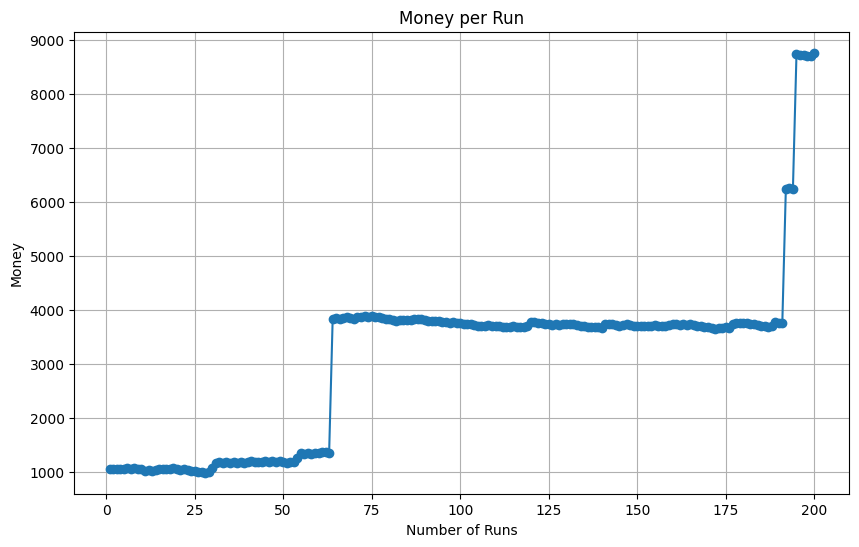


Outcomes and Prizes:
                         Outcome                  Prize
0    Cherries-Green Bar-Blue Bar   1 Cherry + 2 Symbols
1       Blue Bar-Sevens-Cherries   1 Cherry + 2 Symbols
2      Cherries-Sevens-Green Bar   1 Cherry + 2 Symbols
3   Black Bar-Cherries-Black Bar   1 Cherry + 2 Symbols
4    Cherries-Black Bar-Blue Bar   1 Cherry + 2 Symbols
..                           ...                    ...
89     Green Bar-Cherries-Sevens   1 Cherry + 2 Symbols
90          Sevens-Sevens-Sevens               3 Sevens
91  Blue Bar-Cherries-Orange Bar   1 Cherry + 2 Symbols
92          Sevens-Sevens-Sevens               3 Sevens
93  Cherries-Cherries-Orange Bar  2 Cherries + 1 Symbol

[94 rows x 2 columns]

Prize Frequency:
                       Frequency
3 Sevens                       3
3 Black Bars                   0
3 Cherries                     1
2 Cherries + 1 Symbol          6
1 Cherry + 2 Symbols          82
3 Orange Bar                   1
3 Green Bar                    0
3

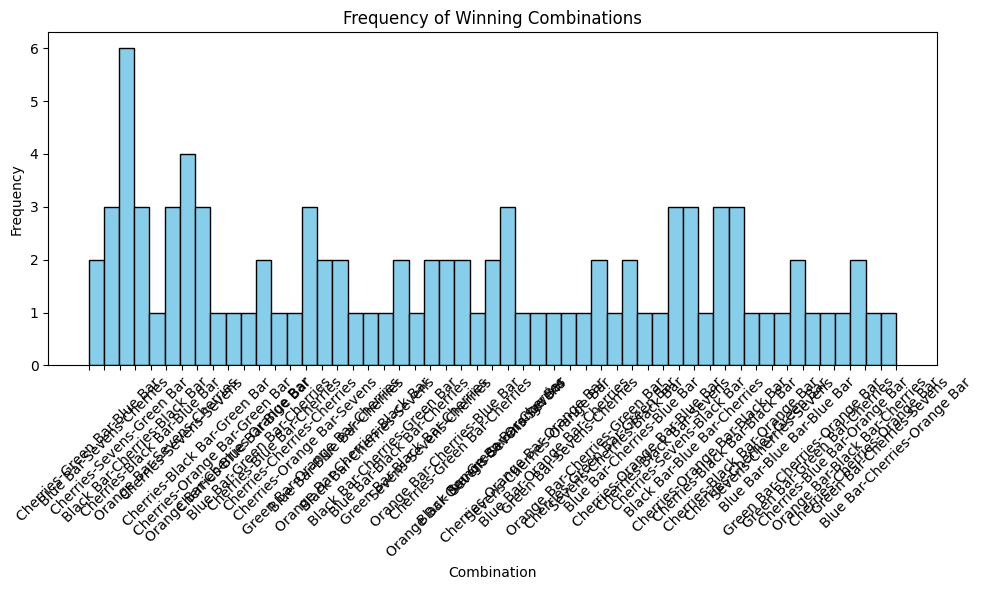


Final Balance after 200 simulations: $8750.00
Number of Bonus Spins obtained: 20


In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.0.75 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1:
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)

    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Plotting histogram for winning combinations
    if win_combinations:
        plt.figure(figsize=(10, 6))
        plt.hist(win_combinations, bins=len(set(win_combinations)), color='skyblue', edgecolor='black')
        plt.title('Frequency of Winning Combinations')
        plt.xlabel('Combination')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


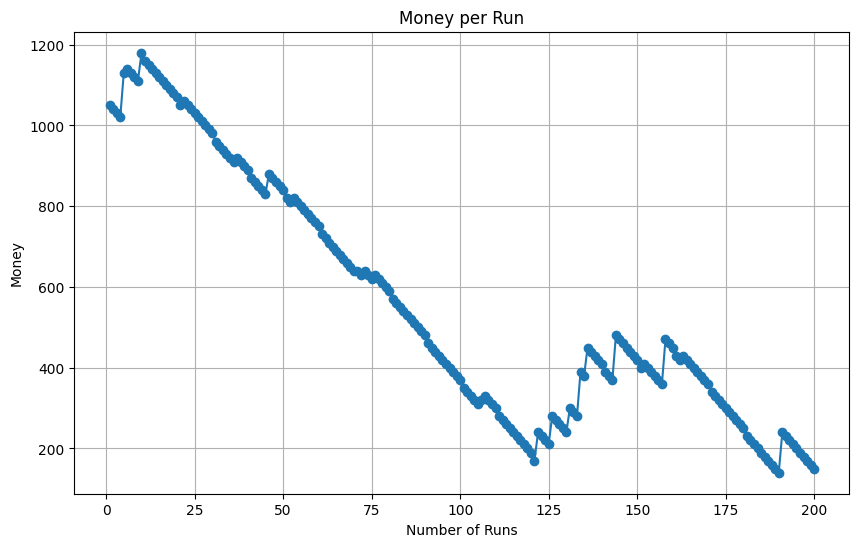


Outcomes and Prizes:
                           Outcome                  Prize
0       Cherries-Cherries-Cherries             3 Cherries
1     Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
2       Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
3   Cherries-Orange Bar-Orange Bar   1 Cherry + 2 Symbols
4           Cherries-Sevens-Sevens   1 Cherry + 2 Symbols
5       Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
6       Cherries-Blue Bar-Blue Bar   1 Cherry + 2 Symbols
7   Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
8           Cherries-Sevens-Sevens   1 Cherry + 2 Symbols
9   Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
10      Blue Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
11  Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
12      Cherries-Blue Bar-Cherries  2 Cherries + 1 Symbol
13      Cherries-Blue Bar-Cherries  2 Cherries + 1 Symbol
14      Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
15      Cherries-Cherries-Cherries             3 C

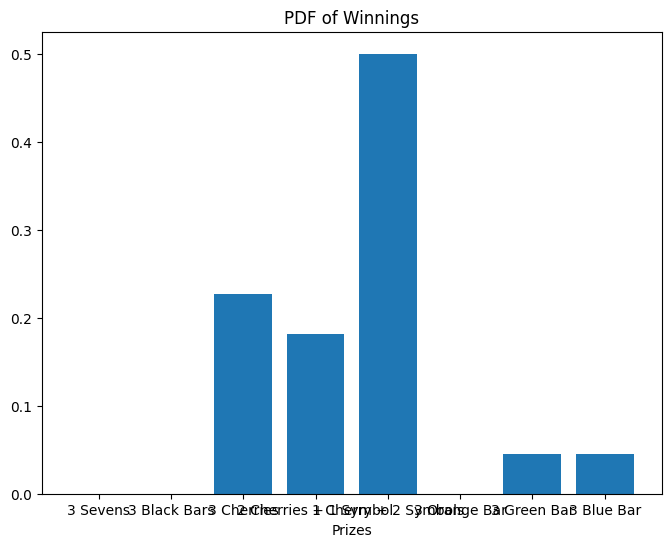

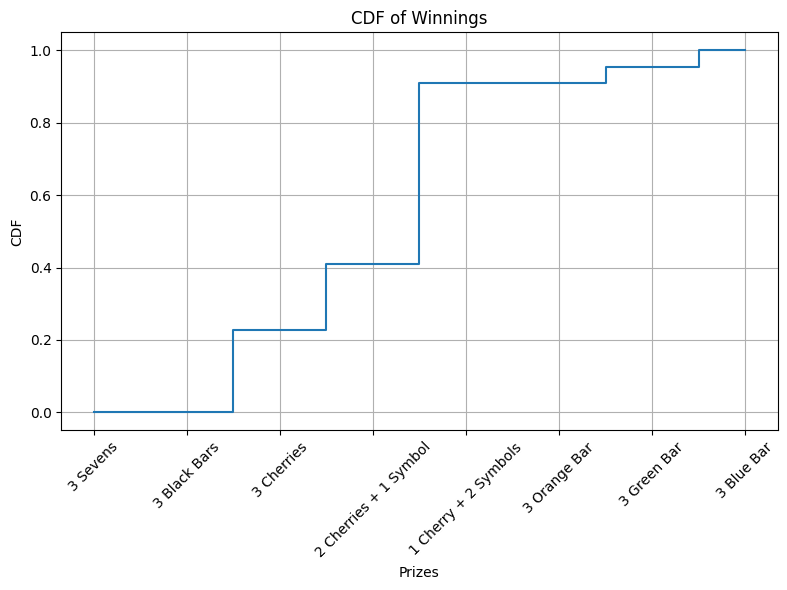


Final Balance after 200 simulations: $130.00
Number of Bonus Spins obtained: 20


In [ ]:
# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}


probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2 and reels.count('Blue Bar') == 1:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1 and (reels.count('Orange Bar')==2 or reels.count('Sevens')==2 or reels.count('Black Bars')==2 or reels.count('Green Bar')==2 or reels.count('Blue Bar')==2):
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Function to run the simulation
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    # Run the simulation
    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Extract only the prizes won from the outcomes
    prizes_won = [outcome[1] for outcome in outcomes_and_prizes if outcome[1] in multipliers]

    # Sort the prizes won based on the desired order
    sorted_prizes = [
        '3 Sevens', '3 Black Bars', '3 Cherries', '2 Cherries + 1 Symbol',
        '1 Cherry + 2 Symbols', '3 Orange Bar', '3 Green Bar', '3 Blue Bar'
    ]

    # Count occurrences of each prize won
    prize_counts = {prize: prizes_won.count(prize) for prize in sorted_prizes}

    # Calculate PDF
    total_winnings = len(prizes_won)
    pdf_values = [count / total_winnings for count in prize_counts.values()]

    # Plotting PDF of winnings
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_prizes, pdf_values)
    plt.title('PDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel

    # Calculate CDF
    cdf_values = np.cumsum(list(prize_counts.values())) / len(prizes_won)

    # Plotting CDF of winnings
    plt.figure(figsize=(8, 6))
    plt.step(sorted_prizes, cdf_values, where='mid')
    plt.title('CDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel('CDF')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


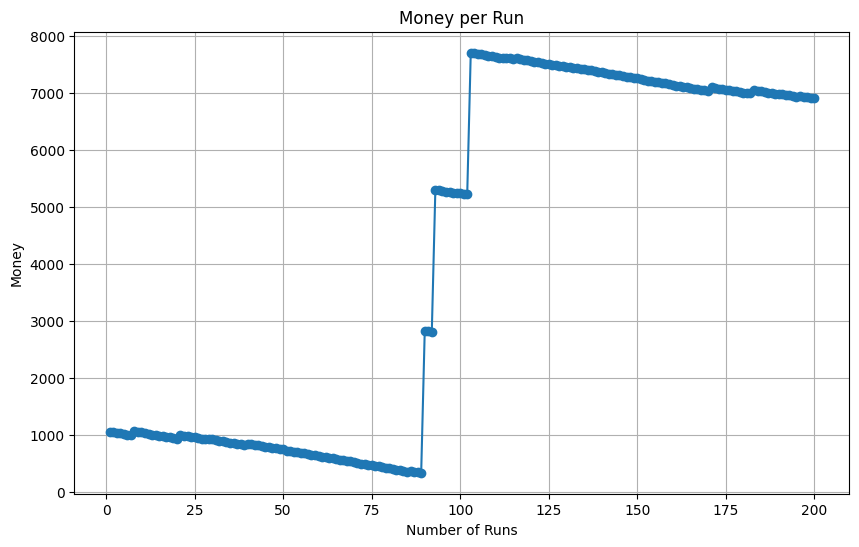


Outcomes and Prizes:
                           Outcome                  Prize
0       Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
1    Green Bar-Green Bar-Green Bar            3 Green Bar
2       Blue Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
3     Cherries-Green Bar-Green Bar   1 Cherry + 2 Symbols
4       Blue Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
5           Cherries-Sevens-Sevens   1 Cherry + 2 Symbols
6             Sevens-Sevens-Sevens               3 Sevens
7     Green Bar-Green Bar-Cherries   1 Cherry + 2 Symbols
8             Sevens-Sevens-Sevens               3 Sevens
9   Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
10            Sevens-Sevens-Sevens               3 Sevens
11    Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
12    Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
13      Blue Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
14   Green Bar-Green Bar-Green Bar            3 Green Bar
15      Cherries-Blue Bar-Blue Bar   1 Cherry + 2 

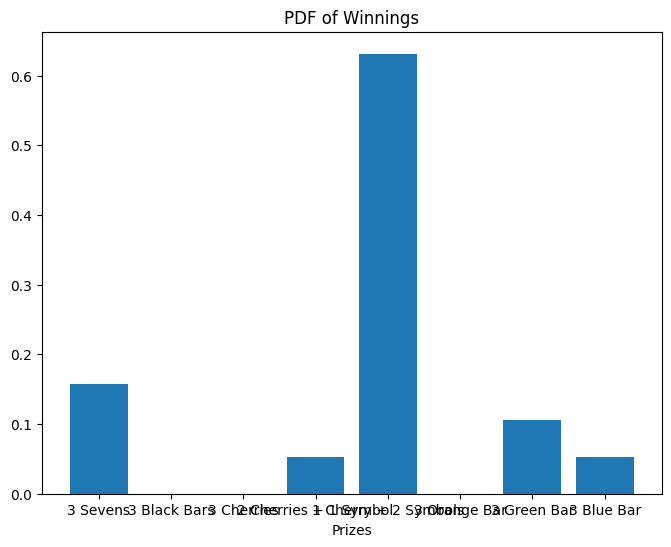

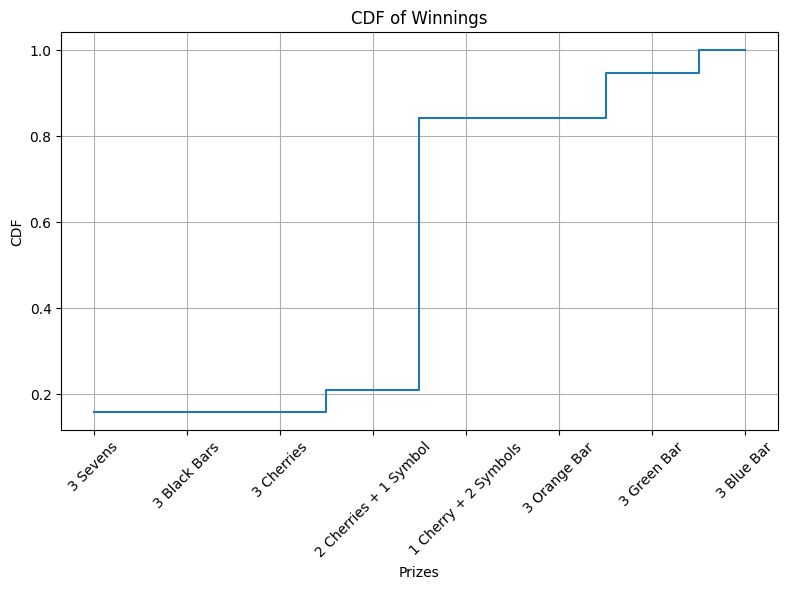


Final Balance after 200 simulations: $6890.00
Number of Bonus Spins obtained: 20


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}


probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2 and reels.count('Blue Bar') == 1:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1 and (reels.count('Orange Bar')==2 or reels.count('Sevens')==2 or reels.count('Black Bars')==2 or reels.count('Green Bar')==2 or reels.count('Blue Bar')==2):
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Function to run the simulation
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    # Run the simulation
    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Extract only the prizes won from the outcomes
    prizes_won = [outcome[1] for outcome in outcomes_and_prizes if outcome[1] in multipliers]

    # Sort the prizes won based on the desired order
    sorted_prizes = [
        '3 Sevens', '3 Black Bars', '3 Cherries', '2 Cherries + 1 Symbol',
        '1 Cherry + 2 Symbols', '3 Orange Bar', '3 Green Bar', '3 Blue Bar'
    ]

    # Count occurrences of each prize won
    prize_counts = {prize: prizes_won.count(prize) for prize in sorted_prizes}

    # Calculate PDF
    total_winnings = len(prizes_won)
    pdf_values = [count / total_winnings for count in prize_counts.values()]

    # Plotting PDF of winnings
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_prizes, pdf_values)
    plt.title('PDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel

    # Calculate CDF
    cdf_values = np.cumsum(list(prize_counts.values())) / len(prizes_won)

    # Plotting CDF of winnings
    plt.figure(figsize=(8, 6))
    plt.step(sorted_prizes, cdf_values, where='mid')
    plt.title('CDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel('CDF')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


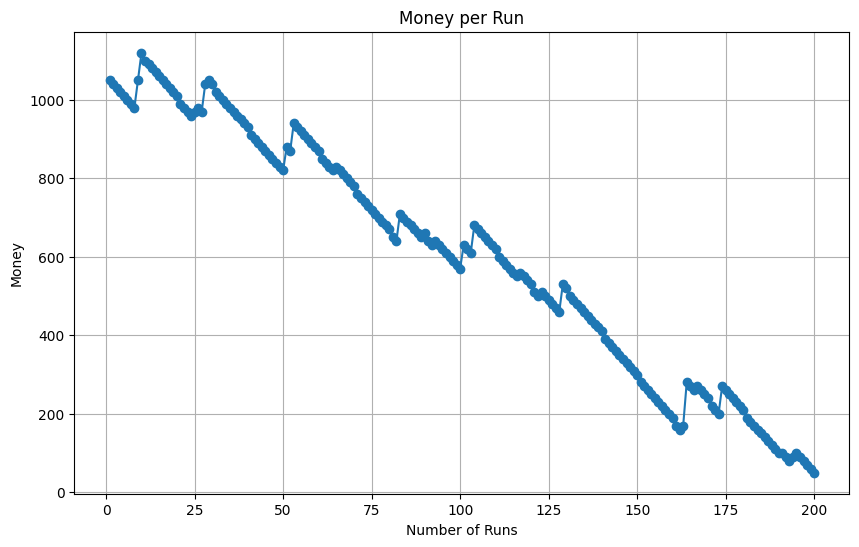


Outcomes and Prizes:
                           Outcome                  Prize
0    Green Bar-Green Bar-Green Bar            3 Green Bar
1       Cherries-Blue Bar-Cherries  2 Cherries + 1 Symbol
2     Green Bar-Green Bar-Cherries   1 Cherry + 2 Symbols
3       Blue Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
4       Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
5       Blue Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
6    Green Bar-Green Bar-Green Bar            3 Green Bar
7    Green Bar-Green Bar-Green Bar            3 Green Bar
8           Cherries-Sevens-Sevens   1 Cherry + 2 Symbols
9       Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
10  Orange Bar-Cherries-Orange Bar   1 Cherry + 2 Symbols
11      Cherries-Blue Bar-Blue Bar   1 Cherry + 2 Symbols
12      Blue Bar-Cherries-Cherries  2 Cherries + 1 Symbol
13      Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
14    Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
15  Orange Bar-Cherries-Orange Bar   1 Cherry + 2 

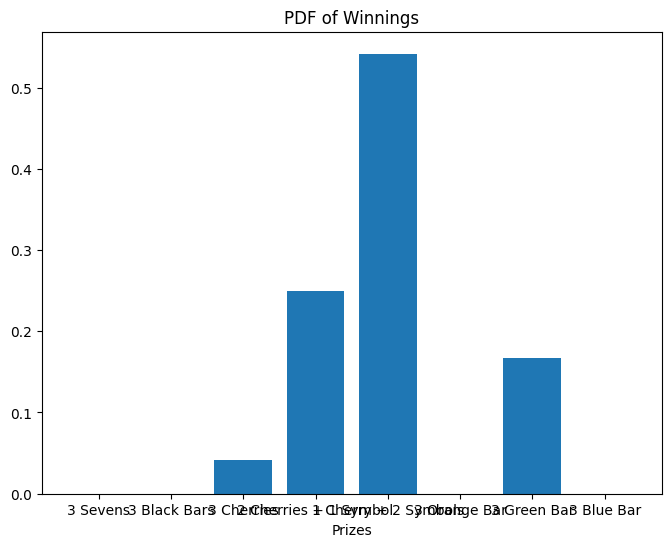

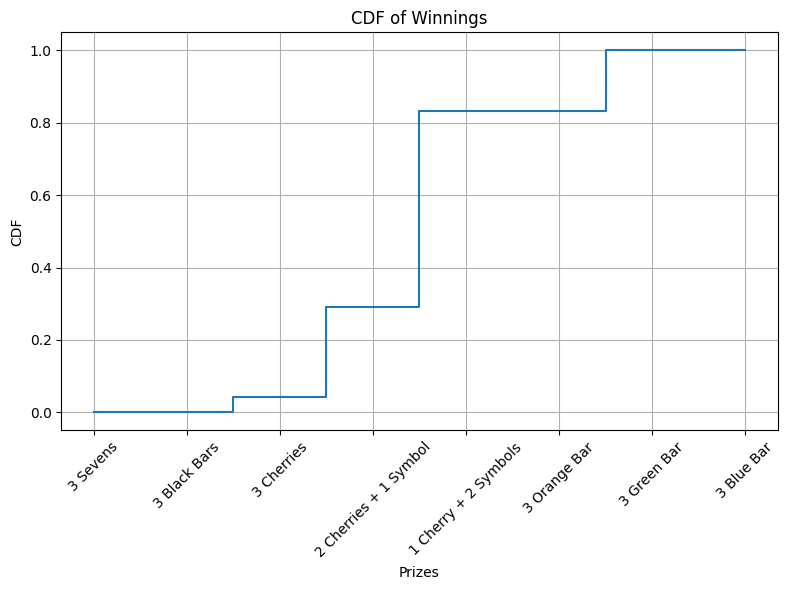


Final Balance after 200 simulations: $30.00
Number of Bonus Spins obtained: 20


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}


probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2 and reels.count('Blue Bar') == 1:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1 and (reels.count('Orange Bar')==2 or reels.count('Sevens')==2 or reels.count('Black Bars')==2 or reels.count('Green Bar')==2 or reels.count('Blue Bar')==2):
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Function to run the simulation
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    # Run the simulation
    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Extract only the prizes won from the outcomes
    prizes_won = [outcome[1] for outcome in outcomes_and_prizes if outcome[1] in multipliers]

    # Sort the prizes won based on the desired order
    sorted_prizes = [
        '3 Sevens', '3 Black Bars', '3 Cherries', '2 Cherries + 1 Symbol',
        '1 Cherry + 2 Symbols', '3 Orange Bar', '3 Green Bar', '3 Blue Bar'
    ]

    # Count occurrences of each prize won
    prize_counts = {prize: prizes_won.count(prize) for prize in sorted_prizes}

    # Calculate PDF
    total_winnings = len(prizes_won)
    pdf_values = [count / total_winnings for count in prize_counts.values()]

    # Plotting PDF of winnings
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_prizes, pdf_values)
    plt.title('PDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel

    # Calculate CDF
    cdf_values = np.cumsum(list(prize_counts.values())) / len(prizes_won)

    # Plotting CDF of winnings
    plt.figure(figsize=(8, 6))
    plt.step(sorted_prizes, cdf_values, where='mid')
    plt.title('CDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel('CDF')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 1000


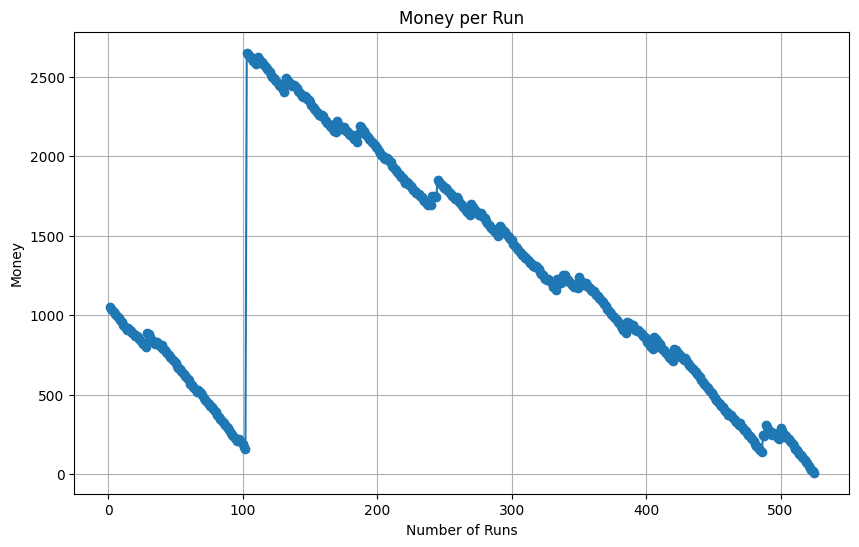


Outcomes and Prizes:
                             Outcome                  Prize
0       Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
1       Cherries-Green Bar-Green Bar   1 Cherry + 2 Symbols
2   Orange Bar-Orange Bar-Orange Bar           3 Orange Bar
3             Cherries-Sevens-Sevens   1 Cherry + 2 Symbols
4         Blue Bar-Cherries-Blue Bar   1 Cherry + 2 Symbols
5     Cherries-Orange Bar-Orange Bar   1 Cherry + 2 Symbols
6         Blue Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
7               Sevens-Sevens-Sevens               3 Sevens
8         Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
9   Orange Bar-Orange Bar-Orange Bar           3 Orange Bar
10    Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
11    Orange Bar-Orange Bar-Cherries   1 Cherry + 2 Symbols
12        Blue Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
13        Cherries-Blue Bar-Cherries  2 Cherries + 1 Symbol
14      Cherries-Green Bar-Green Bar   1 Cherry + 2 Symbols
15    Orange Bar-C

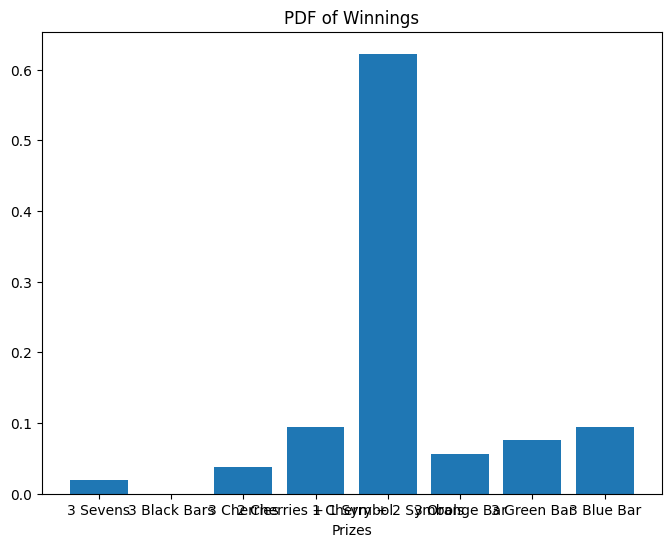

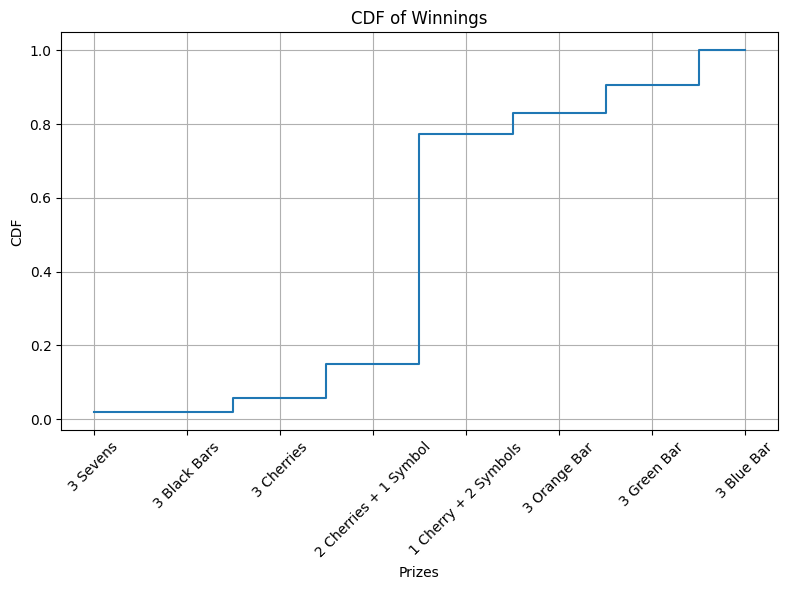


Final Balance after 1000 simulations: $0.00
Number of Bonus Spins obtained: 52


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}


probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2 and reels.count('Blue Bar') == 1:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1 and (reels.count('Orange Bar')==2 or reels.count('Sevens')==2 or reels.count('Black Bars')==2 or reels.count('Green Bar')==2 or reels.count('Blue Bar')==2):
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Function to run the simulation
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    # Run the simulation
    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Extract only the prizes won from the outcomes
    prizes_won = [outcome[1] for outcome in outcomes_and_prizes if outcome[1] in multipliers]

    # Sort the prizes won based on the desired order
    sorted_prizes = [
        '3 Sevens', '3 Black Bars', '3 Cherries', '2 Cherries + 1 Symbol',
        '1 Cherry + 2 Symbols', '3 Orange Bar', '3 Green Bar', '3 Blue Bar'
    ]

    # Count occurrences of each prize won
    prize_counts = {prize: prizes_won.count(prize) for prize in sorted_prizes}

    # Calculate PDF
    total_winnings = len(prizes_won)
    pdf_values = [count / total_winnings for count in prize_counts.values()]

    # Plotting PDF of winnings
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_prizes, pdf_values)
    plt.title('PDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel

    # Calculate CDF
    cdf_values = np.cumsum(list(prize_counts.values())) / len(prizes_won)

    # Plotting CDF of winnings
    plt.figure(figsize=(8, 6))
    plt.step(sorted_prizes, cdf_values, where='mid')
    plt.title('CDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel('CDF')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $1
Enter the number of times you want to run the simulation: 1000


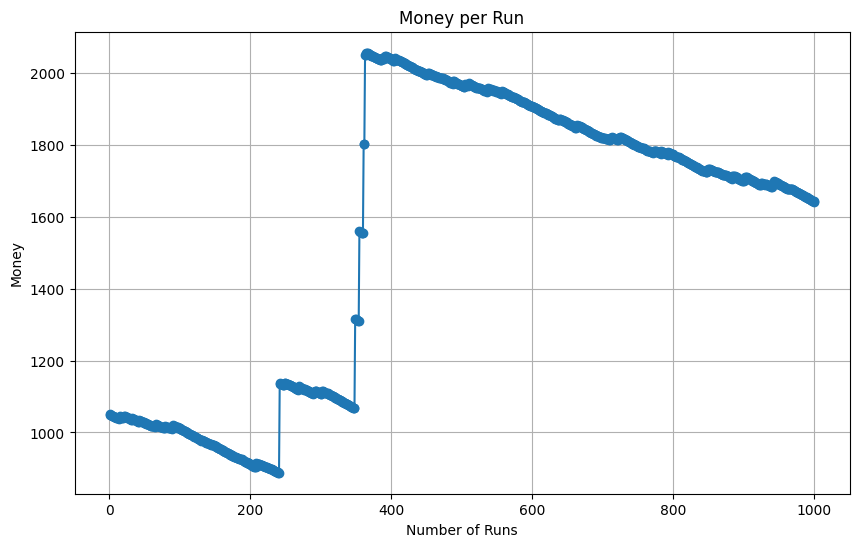


Outcomes and Prizes:
                            Outcome                  Prize
0      Green Bar-Cherries-Green Bar   1 Cherry + 2 Symbols
1        Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
2        Cherries-Cherries-Blue Bar  2 Cherries + 1 Symbol
3        Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
4        Blue Bar-Blue Bar-Blue Bar             3 Blue Bar
..                              ...                    ...
103      Cherries-Cherries-Cherries             3 Cherries
104   Green Bar-Green Bar-Green Bar            3 Green Bar
105          Sevens-Sevens-Cherries   1 Cherry + 2 Symbols
106  Orange Bar-Cherries-Orange Bar   1 Cherry + 2 Symbols
107          Sevens-Sevens-Cherries   1 Cherry + 2 Symbols

[108 rows x 2 columns]

Prize Frequency:
                       Frequency
3 Sevens                       5
3 Black Bars                   0
3 Cherries                     3
2 Cherries + 1 Symbol         21
1 Cherry + 2 Symbols          66
3 Orange Bar                  

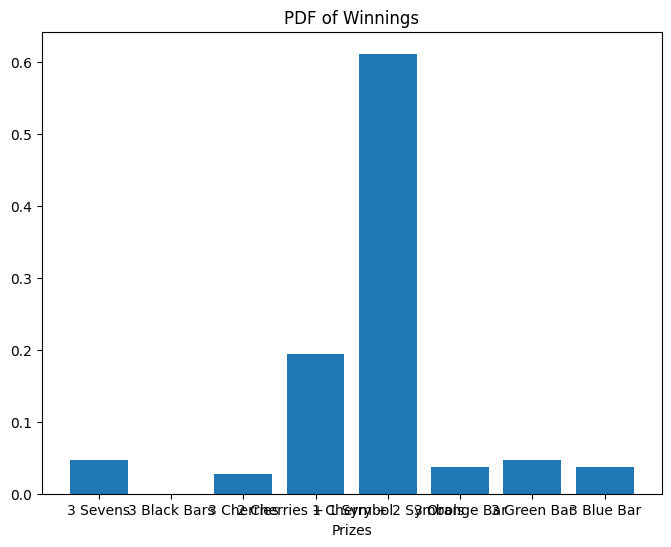

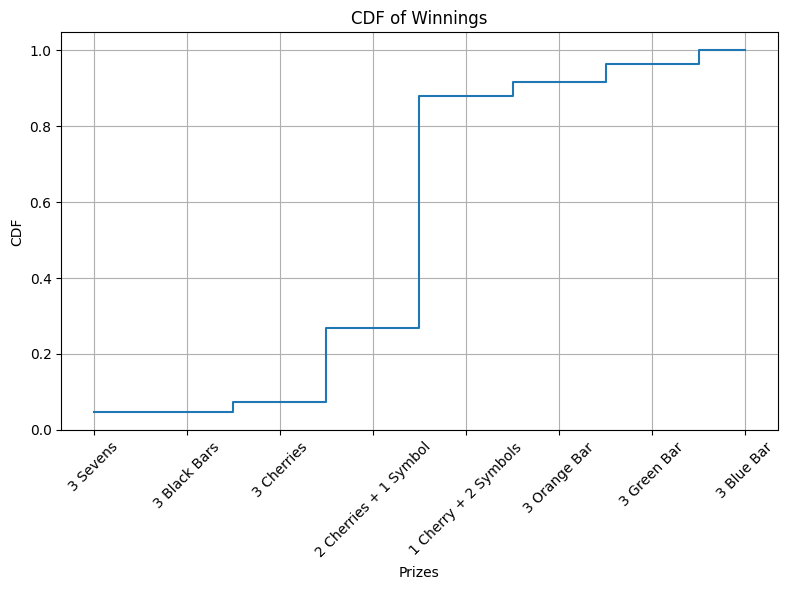


Final Balance after 1000 simulations: $1640.00
Number of Bonus Spins obtained: 100


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}


probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2 and reels.count('Blue Bar') == 1:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1 and (reels.count('Orange Bar')==2 or reels.count('Sevens')==2 or reels.count('Black Bars')==2 or reels.count('Green Bar')==2 or reels.count('Blue Bar')==2):
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Function to run the simulation
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    # Run the simulation
    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Extract only the prizes won from the outcomes
    prizes_won = [outcome[1] for outcome in outcomes_and_prizes if outcome[1] in multipliers]

    # Sort the prizes won based on the desired order
    sorted_prizes = [
        '3 Sevens', '3 Black Bars', '3 Cherries', '2 Cherries + 1 Symbol',
        '1 Cherry + 2 Symbols', '3 Orange Bar', '3 Green Bar', '3 Blue Bar'
    ]

    # Count occurrences of each prize won
    prize_counts = {prize: prizes_won.count(prize) for prize in sorted_prizes}

    # Calculate PDF
    total_winnings = len(prizes_won)
    pdf_values = [count / total_winnings for count in prize_counts.values()]

    # Plotting PDF of winnings
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_prizes, pdf_values)
    plt.title('PDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel

    # Calculate CDF
    cdf_values = np.cumsum(list(prize_counts.values())) / len(prizes_won)

    # Plotting CDF of winnings
    plt.figure(figsize=(8, 6))
    plt.step(sorted_prizes, cdf_values, where='mid')
    plt.title('CDF of Winnings')
    plt.xlabel('Prizes')
    plt.ylabel('CDF')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

# Run the simulation
play()


Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of times you want to run the simulation: 200


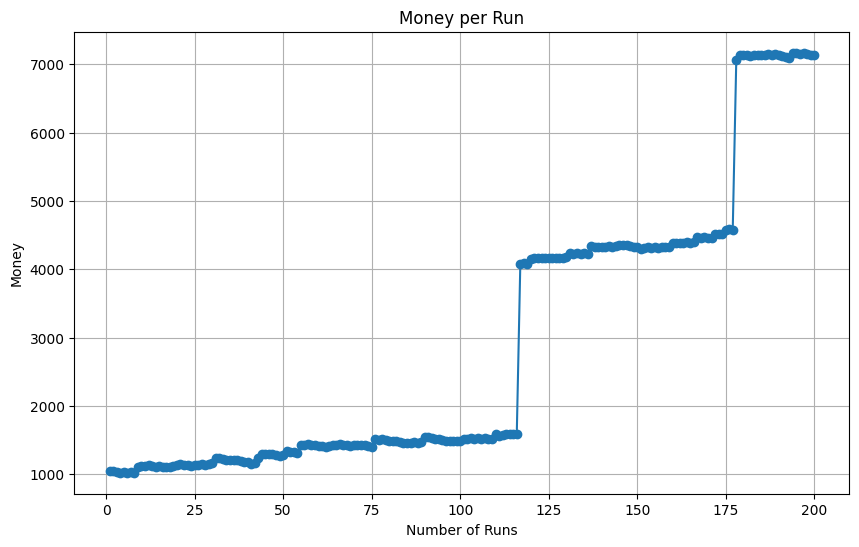


Outcomes and Prizes:
                              Outcome                  Prize
0        Cherries-Black Bar-Black Bar   1 Cherry + 2 Symbols
1            Sevens-Cherries-Blue Bar   1 Cherry + 2 Symbols
2    Orange Bar-Orange Bar-Orange Bar           3 Orange Bar
3           Sevens-Green Bar-Cherries   1 Cherry + 2 Symbols
4          Blue Bar-Blue Bar-Cherries   1 Cherry + 2 Symbols
..                                ...                    ...
101         Green Bar-Cherries-Sevens   1 Cherry + 2 Symbols
102    Cherries-Orange Bar-Orange Bar   1 Cherry + 2 Symbols
103       Cherries-Cherries-Black Bar  2 Cherries + 1 Symbol
104       Cherries-Black Bar-Blue Bar   1 Cherry + 2 Symbols
105      Green Bar-Cherries-Black Bar   1 Cherry + 2 Symbols

[106 rows x 2 columns]

Prize Frequency:
                       Frequency
3 Sevens                       2
3 Black Bars                   0
3 Cherries                     3
2 Cherries + 1 Symbol         12
1 Cherry + 2 Symbols          86
3 Oran

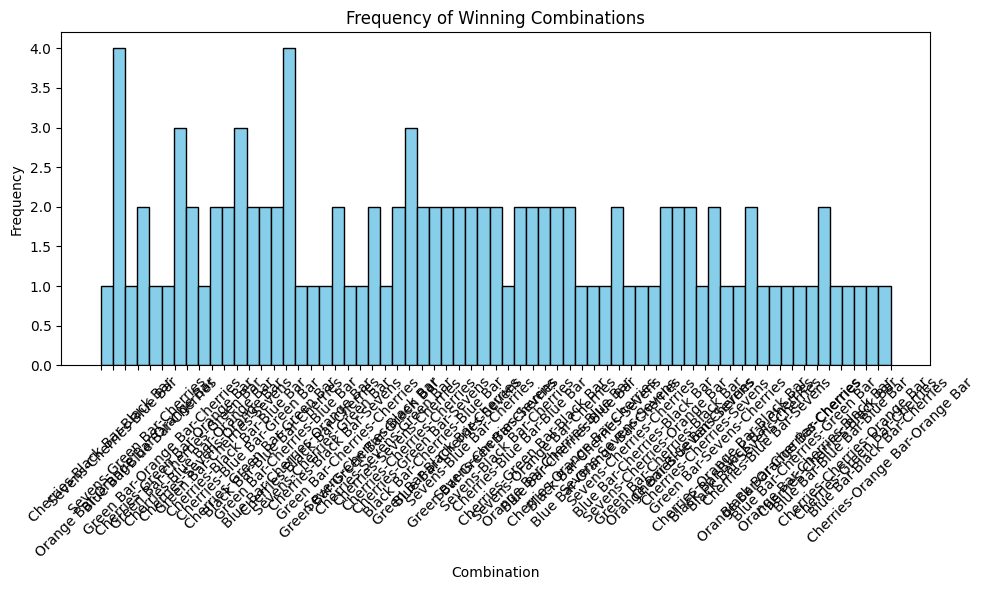


Final Balance after 200 simulations: $7130.00
Number of Bonus Spins obtained: 20


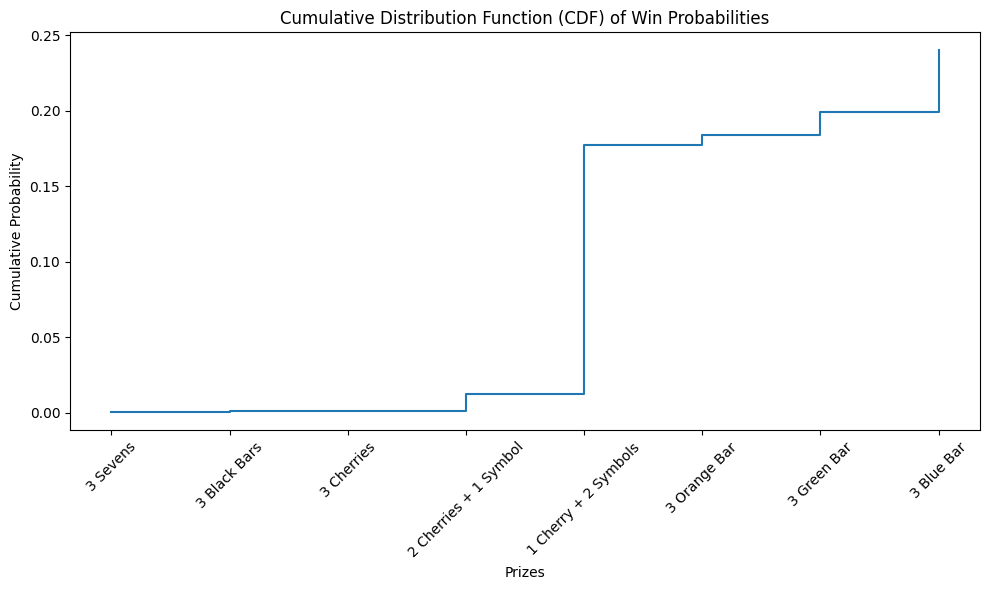

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1:
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to play the simulation
def play():
    starting_money = float(input("Enter your starting amount of money: $"))

    # Calculate bonus based on the initial deposit
    bonus_credits = calculate_bonus(starting_money)

    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")

    # Adjust the starting money based on the bonus
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_simulations = int(input("Enter the number of times you want to run the simulation: "))

    outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count = run_simulation(num_simulations, starting_money, bet_amount)

    # Plotting the money changes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(money_per_run) + 1), money_per_run, marker='o', linestyle='-')
    plt.title('Money per Run')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.grid(True)
    plt.show()

    print("\nOutcomes and Prizes:")
    print(pd.DataFrame(outcomes_and_prizes, columns=['Outcome', 'Prize']))

    print("\nPrize Frequency:")
    print(pd.DataFrame.from_dict(win_count, orient='index', columns=['Frequency']))

    print("\nCombination Frequency:")
    print(pd.DataFrame.from_dict(combination_count, orient='index', columns=['Frequency']))

    # Plotting histogram for winning combinations
    if win_combinations:
        plt.figure(figsize=(10, 6))
        plt.hist(win_combinations, bins=len(set(win_combinations)), color='skyblue', edgecolor='black')
        plt.title('Frequency of Winning Combinations')
        plt.xlabel('Combination')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    print(f"\nFinal Balance after {num_simulations} simulations: ${final_balance:.2f}")
    print(f"Number of Bonus Spins obtained: {bonus_count}")

    # Function to generate CDF from probabilities
    def generate_cdf(probabilities):
        keys = list(probabilities.keys())
        values = list(probabilities.values())
        cdf = [values[0]]

        for i in range(1, len(values)):
            cdf.append(cdf[i - 1] + values[i])

        return keys, cdf

    # Generate CDF from probabilities
    keys, cdf = generate_cdf(probabilities)

    # Function to plot CDF
    def plot_cdf(keys, cdf):
        plt.figure(figsize=(10, 6))
        plt.step(keys, cdf, where='post')
        plt.title('Cumulative Distribution Function (CDF) of Win Probabilities')
        plt.xlabel('Prizes')
        plt.ylabel('Cumulative Probability')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Plot the CDF
    plot_cdf(keys, cdf)

# Run the simulation
play()


##Flow Chart

In [ ]:
!apt-get install graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


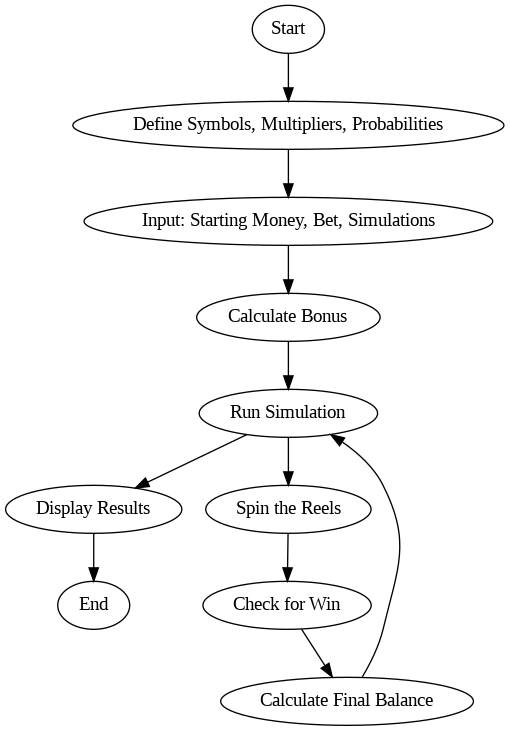

In [ ]:
import pydot
from IPython.display import Image, display

# Inisiasi graph
graph = pydot.Dot(graph_type='digraph')

# Tambahkan nodes
nodes = [
    ('A', 'Start'),
    ('B', 'Define Symbols, Multipliers, Probabilities'),
    ('C', 'Input: Starting Money, Bet, Simulations'),
    ('D', 'Calculate Bonus'),
    ('E', 'Run Simulation'),
    ('F', 'Display Results'),
    ('G', 'End'),
    ('H', 'Spin the Reels'),
    ('I', 'Check for Win'),
    ('J', 'Calculate Final Balance')
]

for node_id, label in nodes:
    node = pydot.Node(node_id, label=label)
    graph.add_node(node)

# Tambahkan edges
edges = [
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'G'),
    ('E', 'H'),
    ('H', 'I'),
    ('I', 'J'),
    ('J', 'E')
]

for edge in edges:
    graph.add_edge(pydot.Edge(*edge))

# Gambar graph
graph.write_png('/content/flowchart.png')
display(Image('/content/flowchart.png'))


###Perhitungan RTP

In [ ]:
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

exp_winnings = 250*0.000244 + 15*0.000824 + 12*0.000244 + 8*0.010986 + 2*0.164795 + 10*0.006592 + 8*0.015625 + 6*0.040619
print(exp_winnings)

0.9284


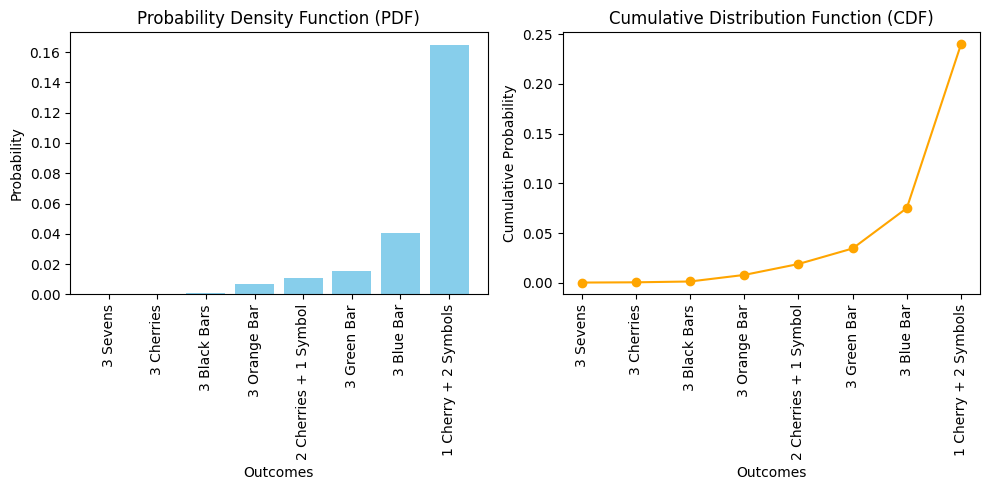

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given probabilities
probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Sort probabilities by their values
sorted_probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1]))

# Extract labels and probabilities
labels = list(sorted_probabilities.keys())
prob_vals = list(sorted_probabilities.values())

# Plotting PDF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, prob_vals, color='skyblue')
plt.title('Probability Density Function (PDF)')
plt.xlabel('Outcomes')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.tight_layout()

# Plotting CDF
cumulative_prob = np.cumsum(prob_vals)
plt.subplot(1, 2, 2)
plt.plot(labels, cumulative_prob, marker='o', color='orange', linestyle='-')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Outcomes')
plt.ylabel('Cumulative Probability')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


#SIMULATION TOTAL GRAPHICS

Enter your starting amount of money: $1000

Bonus Credits obtained: $50.00
Enter your bet amount: $10
Enter the number of runs per simulation: 200
Enter the total number of simulations to run: 1000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


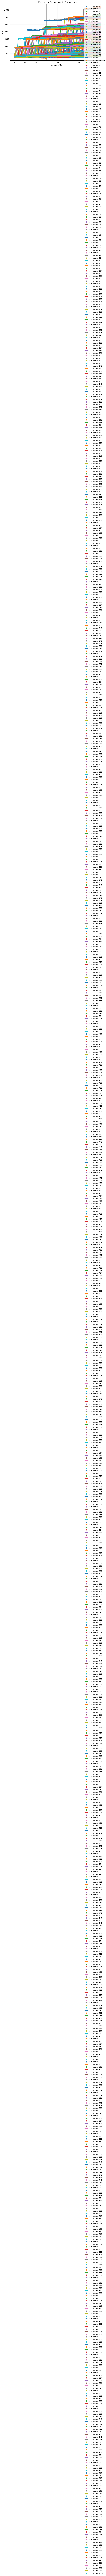

In [ ]:
import random
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Define the symbols for the reels
symbols = ['Sevens', 'Black Bar', 'Cherries', 'Orange Bar', 'Green Bar', 'Blue Bar']

# Define the prize multipliers and probabilities separately
multipliers = {
    '3 Sevens': 250,
    '3 Black Bars': 15,
    '3 Cherries': 12,
    '2 Cherries + 1 Symbol': 8,
    '1 Cherry + 2 Symbols': 2,
    '3 Orange Bar': 10,
    '3 Green Bar': 8,
    '3 Blue Bar': 6
}

probabilities = {
    '3 Sevens': 0.000244,
    '3 Black Bars': 0.000824,
    '3 Cherries': 0.000244,
    '2 Cherries + 1 Symbol': 0.010986,
    '1 Cherry + 2 Symbols': 0.164795,
    '3 Orange Bar': 0.006592,
    '3 Green Bar': 0.015625,
    '3 Blue Bar': 0.040619
}

# Function to calculate bonus based on initial deposit
def calculate_bonus(initial_amount):
    if 1000 <= initial_amount <= 5000:
        return 0.05 * initial_amount
    elif 5001 <= initial_amount <= 10000:
        return 0.075 * initial_amount
    elif initial_amount >= 10001:
        return 0.10 * initial_amount
    else:
        return 0

# Function to spin the reels
def spin():
    return [random.choice(symbols) for _ in range(3)]

# Function to check for a win and return the prize won
def check_win(reels):
    outcome = '-'.join(reels)

    # Checking for specific combinations and assigning the corresponding prize
    if reels.count('Sevens') == 3:
        return '3 Sevens'
    elif reels.count('Black Bars') == 3:
        return '3 Black Bars'
    elif reels.count('Cherries') == 3:
        return '3 Cherries'
    elif reels.count('Cherries') == 2:
        return '2 Cherries + 1 Symbol'
    elif reels.count('Cherries') == 1:
        return '1 Cherry + 2 Symbols'
    elif reels.count('Orange Bar') == 3:
        return '3 Orange Bar'
    elif reels.count('Green Bar') == 3:
        return '3 Green Bar'
    elif reels.count('Blue Bar') == 3:
        return '3 Blue Bar'

    # Return the combination if no prize is won
    return outcome

# Main simulation function
def run_simulation(num_simulations, starting_money, bet_amount):
    outcomes_and_prizes = []  # Track outcomes and prizes
    win_count = {prize: 0 for prize in probabilities.keys()}  # Track prize frequency
    combination_count = {combo: 0 for combo in set('-'.join(reels) for reels in itertools.product(symbols, repeat=3))}
    win_combinations = []  # Track the winning combinations

    total_money = starting_money  # Track the total money across simulations
    money_per_run = []  # Track money for plotting
    bonus_count = 0  # Track the number of bonus spins

    for i in range(1, num_simulations + 1):
        if total_money < bet_amount:
            break

        money_per_run.append(total_money)  # Append the current money for plotting

        reels = spin()
        result = check_win(reels)

        if result in multipliers:
            win_combinations.append('-'.join(reels))  # Track the winning combinations
            outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
            total_money += bet_amount * multipliers[result] - bet_amount
            win_count[result] += 1
        else:
            total_money -= bet_amount

        combination_count['-'.join(reels)] += 1  # Track combination frequency

        # Check for bonus spin every 10 spins
        if i % 10 == 0:
            bonus_count += 1
            reels = spin()
            result = check_win(reels)

            if result in multipliers:
                win_combinations.append('-'.join(reels))  # Track the winning combinations
                outcomes_and_prizes.append(('-'.join(reels), result))  # Track outcomes and prizes
                total_money += bet_amount * multipliers[result] - bet_amount
                win_count[result] += 1
            else:
                total_money -= bet_amount

            combination_count['-'.join(reels)] += 1  # Track combination frequency

    # Final balance calculation after all simulations
    final_balance = total_money
    return outcomes_and_prizes, win_count, combination_count, final_balance, money_per_run, win_combinations, bonus_count

# Function to run multiple simulations
def multiple_simulations(num_total_simulations, num_runs_per_simulation, starting_money, bet_amount):
    all_money_per_run = []

    for _ in range(num_total_simulations):
        _, _, _, _, money_per_run, _, _ = run_simulation(num_runs_per_simulation, starting_money, bet_amount)
        all_money_per_run.append(money_per_run)

    return all_money_per_run

# Updated play function to handle multiple simulations
def play():
    starting_money = float(input("Enter your starting amount of money: $"))
    bonus_credits = calculate_bonus(starting_money)
    print(f"\nBonus Credits obtained: ${bonus_credits:.2f}")
    starting_money += bonus_credits

    bet_amount = float(input("Enter your bet amount: $"))
    num_runs_per_simulation = int(input("Enter the number of runs per simulation: "))
    num_total_simulations = int(input("Enter the total number of simulations to run: "))

    all_money_per_run = multiple_simulations(num_total_simulations, num_runs_per_simulation, starting_money, bet_amount)

    # Plotting the results of all simulations
    plt.figure(figsize=(10, 6))
    for i, money_run in enumerate(all_money_per_run):
        plt.plot(range(1, len(money_run) + 1), money_run, marker='o', linestyle='-', label=f'Simulation {i+1}')
    plt.title('Money per Run Across All Simulations')
    plt.xlabel('Number of Runs')
    plt.ylabel('Money')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
play()
